# Problem Set 4 (PS4): Comparison of Portfolio Allocation Approaches
In this problem set, students will construct a minimum variance portfolio and compare the performance of that portfolio with an equally weighted alternative and the [SP500 Index Fund `SPY`](https://finance.yahoo.com/quote/SPY/). This will be an out-of-sample `2024` comparison based on [single index models](https://en.wikipedia.org/wiki/Single-index_model) estimated using data from `2018` to `2023`.

### Learning objectives
* __Prerequisites__: Load and clean the testing dataset. In this section, we load the [single index models](https://en.wikipedia.org/wiki/Single-index_model) we estimated previously, load the out-of-sample dataset, and set constants.
* __Task 1__: Compute Single Index Minimum Variance Portfolios. In this task, we'll compute the efficient frontier and the initial allocation for an efficient portfolio for the asset tickers you select.
* __Task 2__: Compute Equally Weighted Portfolio. In this task, we'll construct an equally weighted portfolio of your specified assets.
* __Task 3__: Task 3: Which approach should we choose? In this task, we'll compare the three investment approaches and determine which performs better.

## Setup
We set up the computational environment by including [the `Include.jl` file](Include.jl). The [`Include.jl` file](Include.jl) loads external packages, various functions we will use in the exercise, and custom types to model the components of our problem.
* See the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) for additional information on functions and types used in this material. 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the testing dataset
In this section, we load the [single index models](https://en.wikipedia.org/wiki/Single-index_model) we estimated previously, load the out-of-sample dataset, and set constants. 

### Testing data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2024` until `10-25-24` close, along with data for a few exchange-traded funds and volatility products during that time. We load the `prediction_dataset` by calling the `MyOutOfSampleMarketDataSet()` function:

In [5]:
out_of_sample_dataset = MyOutOfSampleMarketDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 489 entries:
  "NI"   => 206×8 DataFrame…
  "EMR"  => 206×8 DataFrame…
  "CTAS" => 206×8 DataFrame…
  "HSIC" => 206×8 DataFrame…
  "KIM"  => 206×8 DataFrame…
  "PLD"  => 206×8 DataFrame…
  "IEX"  => 206×8 DataFrame…
  "BAC"  => 206×8 DataFrame…
  "CBOE" => 206×8 DataFrame…
  "EXR"  => 206×8 DataFrame…
  "NCLH" => 206×8 DataFrame…
  "CVS"  => 206×8 DataFrame…
  "DRI"  => 206×8 DataFrame…
  "DTE"  => 206×8 DataFrame…
  "ZION" => 206×8 DataFrame…
  "AVY"  => 206×8 DataFrame…
  "EW"   => 206×8 DataFrame…
  "EA"   => 206×8 DataFrame…
  "NWSA" => 206×8 DataFrame…
  "BBWI" => 206×8 DataFrame…
  "CAG"  => 206×8 DataFrame…
  "GPC"  => 206×8 DataFrame…
  "FCX"  => 206×8 DataFrame…
  "GILD" => 206×8 DataFrame…
  "INFO" => 12×8 DataFrame…
  ⋮      => ⋮

Now, let's get the number of trading days of data that we have to experiment with. 

In [7]:
number_of_trading_days = out_of_sample_dataset["AAPL"] |> nrow; # max number of days, you can reset for shorter durations

### Load single index models and compute the covariance
Previously, we estimated the parameters and residual distributions for each `ticker` using data from `2018` to `2023` and saved these models to a [JLD2.jl file](https://github.com/JuliaIO/JLD2.jl). Load this file using the [load(...) function](https://juliaio.github.io/JLD2.jl/stable/#save-and-load-functions). 
* Store the model collection in the `sim_model_dictionary` variable, where the keys of the dictionary are the ticker symbols and the values are the parameterized [MySingleIndexModel instances](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MySingleIndexModel) estimated previously.

In [9]:
sim_model_dictionary = load(joinpath(_PATH_TO_DATA, "SIMs-SP500-01-03-18-to-12-29-23.jld2")) |> x->x["sim"]

Dict{String, MySingleIndexModel} with 460 entries:
  "NI"   => MySingleIndexModel(-0.0671224, 0.652999, 0.0389, Normal{Float64}(μ=…
  "EMR"  => MySingleIndexModel(-0.0549877, 1.23526, 0.0389, Normal{Float64}(μ=-…
  "CTAS" => MySingleIndexModel(0.119417, 1.17936, 0.0389, Normal{Float64}(μ=-6.…
  "HSIC" => MySingleIndexModel(-0.0811194, 0.913675, 0.0389, Normal{Float64}(μ=…
  "KIM"  => MySingleIndexModel(-0.0818621, 1.28859, 0.0389, Normal{Float64}(μ=-…
  "PLD"  => MySingleIndexModel(0.0273092, 1.02836, 0.0389, Normal{Float64}(μ=1.…
  "IEX"  => MySingleIndexModel(-0.00940007, 0.963259, 0.0389, Normal{Float64}(μ…
  "BAC"  => MySingleIndexModel(-0.0922207, 1.32778, 0.0389, Normal{Float64}(μ=-…
  "CBOE" => MySingleIndexModel(-0.00982405, 0.588498, 0.0389, Normal{Float64}(μ…
  "EXR"  => MySingleIndexModel(0.0252878, 0.725388, 0.0389, Normal{Float64}(μ=3…
  "NCLH" => MySingleIndexModel(-0.336719, 2.32891, 0.0389, Normal{Float64}(μ=1.…
  "CVS"  => MySingleIndexModel(-0.0703279, 0.78292, 0.0389

Next, let's build a sorted list of firms that we have in cleaned up `sim_model_dictionary::Dict{String, MySingleIndexModel}` and save it in the `list_of_all_tickers::Array{String,1}` array:

In [11]:
list_of_all_tickers = keys(sim_model_dictionary) |> collect |> sort; # sorted list of all tickers
number_of_tickers = length(list_of_all_tickers); # how many *total* tickers do we have?

### Constants
Set constants that we'll use later. Please see the comment next to the constant value for a description of the constant, permissible values, etc.

In [13]:
σₘ = 0.1621; # implied volatility for SPY
Rₘ = 0.06; # assumed expected excess return for SPY (historical)
risk_free_rate = 0.0389; # hypothetical continuous compounded risk-free rate (units: 1/year)
Δt = (1.0/252.0); # time step for 1-trading day (units: 1/year)
my_total_budget = 1000.0; # investment budget
ϵ = 0.05; # risk tolerance
startdate = Date(2024,01,03); # We will start our portfolio at the close of this day

### Alternative investment
In this study, we'll use `SPY` as a hypothetical alternative investment, i.e., we'll invest our budget $\mathcal{B}$ in in `SPY` instead of our portfolio $\mathcal{P}$. Toward this, let's compute the number of shares of `SPY` to purchase, which we store in the `n_spy::Float64` variable, and capture the close price of `SPY` in the `S_spy::Array{Float64,1}` array.

In [15]:
(n_spy, S_spy) = let
    price_df = out_of_sample_dataset["SPY"];
    startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
    nᵢ = (my_total_budget)/startprice;
    S = price_df[:,:close];
    nᵢ,S
end;

### Compute the expected excess returns using single index models
Here, we compute the expected return for each ticker in the `list_of_all_tickers::Array{String,1}` array  using the single index models calculated previously using a `for-loop.` For iteration of the loop:
* Get the `ticker` symbol from the `list_of_all_tickers` array, and pull out the corresponding single index model from the `sim_model_dictionary` dictionary. Then, pull out the $(\alpha, \beta)$ parameters from the `sim` model instance and compute the expected return $\mathbb{E}(R_{i})$. Store the expected return in the `μ_sim::Array{Float64,1}` array

In [17]:
μ_sim = Array{Float64,1}();
for i ∈ eachindex(list_of_all_tickers)
    sim = list_of_all_tickers[i] |> ticker -> sim_model_dictionary[ticker];   
    αᵢ = sim.α
    βᵢ = sim.β
    (αᵢ+βᵢ*Rₘ) |> R̄ᵢ-> push!(μ_sim,R̄ᵢ); # evaluate the SIM for all the models in our collection
end

### Compute the covariance matrix using single index models
Next, we build the covariance array using single index models. Substituting the single index model for the excess return of asset $i$ and $j$ into the covariance expression (and simplifying) gives:
$$
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}
$$
where $\sigma_{m}^2$ denotes the variance of the excess return of the market, and $\sigma_{\epsilon_{i}}^{2}$ denotes the variance of the firm-specific error model (estimated when we constructed the single index models). To compute the risk $\sigma_{m}$, which is the standard deviation of the return for the market portfolio, we use the [implied volatility of `SPY` options](https://marketchameleon.com/Overview/SPY/IV/). We save the single index model estimate of the covariance array in the `Σ_sim::Array{Float64,2}` variable:

In [19]:
Σ_sim = let
    Σ_tmp = Array{Float64,2}(undef, number_of_tickers, number_of_tickers);
    for i ∈ eachindex(list_of_all_tickers)
        
        outer_ticker = list_of_all_tickers[i]; # ticker on the rows 
        sim_outer = sim_model_dictionary[outer_ticker]; # get SIM model for row ticker
        
        for j ∈ eachindex(list_of_all_tickers)
            
            inner_ticker = list_of_all_tickers[j]; # ticker in the cols
            sim_inner = sim_model_dictionary[inner_ticker]; # get SIM model of the col ticker
            
            if (i == j) # we have a diagonal element
                βᵢ = sim_outer.β
                ϵᵢ = sim_outer.ϵ
                σ_ϵᵢ = params(ϵᵢ)[2];
                Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
            else
                βᵢ = sim_outer.β
                βⱼ = sim_inner.β
                Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
            end
        end
    end
    Σ_sim  = Σ_tmp |> x-> x*Δt # annualize
end;

## Task 1: Compute Single Index Minimum Variance Portfolios
In this task, we'll compute the efficient frontier and the initial allocation for an efficient portfolio for the asset tickers you select. To start, select $N\geq{10}$ assets from our collection of assets from the entries in the `list_of_all_tickers::Array{String,1}` array for your portfolio.
* __What tickers can you chose__? You can choose any ticker symbol for which we have a single index model instance and for which we have out-of-sample test data (the ticker symbols in the `out_of_sample_dataset::Dict{String, DataFrame}` are the keys in this dictionary.) 

In [21]:
my_list_of_tickers = ["NVDA", "AMD", "MU", "AAPL", "MSFT", "GS", "BAC", "JPM", "WFC", "MRK", "PFE", "JNJ", "TSLA", 
    "COST", "TGT", "K"];

#### Check: Do we have your tickers?
Before getting too far, let's check that we have data for the ticker symbols you selected in the `my_list_of_tickers::Array{String,1}` array. First, we'll check that we have the corresponding single index model and then see if we have the out-of-sample data for each ticker.

In [23]:
for i ∈ eachindex(my_list_of_tickers)
    ticker = my_list_of_tickers[i];

    # check 1: do we have a SIM for this ticker?
    if (haskey(sim_model_dictionary, ticker) == false)
        println("Ooops! We don't have a SIM for ticker: $(ticker)");
        @assert false; # this will throw an AssertionError
    end

    # check 2: do we have the out-of-sample data?
     if (haskey(out_of_sample_dataset, ticker) == false)
        println("Ooops! We don't have out of sample data for ticker: $(ticker)");
        @assert false; # this will throw an AssertionError
    end
end

### Covariance, return, initial prices
We'll now get the data required to solve the minimum variance portfolio problem. 
First, get the share price at the close of the market on `startdate::Date` for each asset in your portfolio. We'll store these values in the `Sₒ::Array{Float64,1}` array (and use them to calculate our initial allocation later):

In [25]:
Sₒ = let
    Sₒ = Array{Float64,1}()
    for ticker ∈ my_list_of_tickers
        price_df = out_of_sample_dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
        push!(Sₒ,startprice)
    end
    Sₒ;
end;

* `Unhide` the code block below to see how we make a table that shows the initial share prices (at market close) for each `ticker` $\in$ `my_list_of_tickers` on the first day of hypothetical trading specified by `startdate::Date`

In [27]:
let
    df = DataFrame()
    for ticker ∈ my_list_of_tickers
        price_df = out_of_sample_dataset[ticker];
        startprice = filter(:timestamp => x-> x >= startdate, price_df) |> x-> x[1,:close]
        row_df = (
            date = startdate,
            ticker = ticker,
            initial_share_price = startprice
        );
        push!(df, row_df);
    end
    pretty_table(df, tf=tf_simple)
end

============= ======== ======================
        date   ticker   initial_share_price 
        Date   String               Float64 
============= ======== ======================
  2024-01-03     NVDA                47.569
  2024-01-03      AMD                135.32
  2024-01-03       MU                 82.26
  2024-01-03     AAPL                184.25
  2024-01-03     MSFT                 370.6
  2024-01-03       GS                381.79
  2024-01-03      BAC                 33.53
  2024-01-03      JPM                171.33
  2024-01-03      WFC                 48.68
  2024-01-03      MRK                114.77
  2024-01-03      PFE                 29.73
  2024-01-03      JNJ                160.97
  2024-01-03     TSLA                238.45
  2024-01-03     COST                644.69
  2024-01-03      TGT                138.67
  2024-01-03        K                 57.48
============= ======== ======================


Next, we calculate the firm-specific expected return vector $\hat{\mu}$ and covariance matrix $\hat{\Sigma}$. We will store these in $\hat{\mu}::Array{Float64,1}$ and $\hat{\Sigma}::Array{Float64,2}$ variables. 
* We already computed these values for all tickers in our collection in the prerequisites; now, we need to grab only the data associated with your ticker collection specified in the `my_list_of_tickers::Array{String,1}`. We'll do this for you, so please do not edit this code block.

In [29]:
# --- DO NOT CHANGE THE CODE BELOW -------------------------------------------------------------------- #
μ̂, Σ̂ = let

    my_list_of_firm_ids = Array{Int64,1}();
    for ticker ∈ my_list_of_tickers
        findfirst(x->x==ticker, list_of_all_tickers) |> i -> push!(my_list_of_firm_ids, i);
    end
    my_number_of_selected_firms = length(my_list_of_firm_ids)

    # Expected excess return
    μ̂ = Array{Float64,1}();
    for firm_index ∈ my_list_of_firm_ids
        push!(μ̂, μ_sim[firm_index])
    end
    
    # Covariance
    Σ̂ = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
    for i ∈ eachindex(my_list_of_firm_ids)
        row_firm_index = my_list_of_firm_ids[i]
        for j ∈ eachindex(my_list_of_firm_ids)
            col_firm_index = my_list_of_firm_ids[j]
            Σ̂[i,j] = Σ_sim[row_firm_index, col_firm_index]
        end
    end

    μ̂, Σ̂
end;
# --- DO NOT CHANGE THE CODE ABOVE -------------------------------------------------------------------- #

### Compute the efficient frontier
Now, we can compute the single index model minimum variance efficient frontier, assuming only risky assets. We start by setting up the bounds and constants in the problem (see the comment next to value for a description of the constant, permissible values, etc).

In [31]:
N = length(my_list_of_tickers); # how many tickers did we select?
wₒ = zeros(N); # initial guess for allocation
wₒ[1] = 1.0; # everything in asset 1 (initially)
bounds = zeros(N,2); # bounds are a N x 2 array, first col is the lower bound, second col is the upper bound
bounds[:,2] .= 1.0; # set the upper bound to 1.0 for each ticker. The .= is a vector operator 
number_of_points = 100; # how many portfolios do we want to create? (this will be an upper bound, as some may be infeasible)

Next, create an instance of the [MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). Store this in the `problem_risk` variable. You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem},%20NamedTuple}). 

In [33]:
problem_risk = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂, # single index model cov matrix
    μ = μ̂, # single index model expected return
    bounds = bounds,
    initial = wₒ,
    R = 0.0 # why zero? We'll update this value later ...
));

Now, create an array with the minimum desired rewards (the calculation must achieve at least this much reward). In this case, assume we go from `0` to `10`$\times{r_{f}}$ and take `number_of_points` steps.  We store these values in the `minimum_desired_reward_array::Array{Float64,1}` variable.
* __What is this for?__: This array specifies the lower bound of our desired portfolio return. Thus, we are asking the QP solver to find an allocation that achieves _at least_ this desired level of return for the minimum risk. Second, this is an _excess return_ array, thus it `0` corresponds to the risk free rate.

In [35]:
minimum_desired_reward_array = range(0.0, stop = 10*risk_free_rate, length = number_of_points) |> collect; # excess return from zero

Finally, we iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level [using a `for-loop.`](https://docs.julialang.org/en/v1/base/base/#for) For each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem_risk` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk $\sigma_{\mathcal{P}}$ as the `key` and the portfolio's expected return as the `value` in the `efficient_frontier` dictionary.
* __Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)__? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation is feasible. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to solve for some reason. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [37]:
efficient_frontier = let
    efficient_frontier = Dict{Float64,Float64}();
    for i ∈ eachindex(minimum_desired_reward_array)
        
        # update the problem object -
        problem_risk.R = minimum_desired_reward_array[i]; # update the lower bound on desired return
    
        try
            # call to the solver 
            solution = solve(problem_risk)
    
            # check: did this converge?
            status_flag = solution["status"];    
            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                key = sqrt(solution["objective_value"]);
                efficient_frontier[key] = solution["reward"];
            end
        catch err
            # Uncomment to see which R's failed ...
            # println("Failed: desired R = $(problem_risk.R). Infeasible - $(err)");
        end
    end
    efficient_frontier;
end;

### Visualize
`Unhide` the code block below to see how we plotted the efficient frontier for your collection of risk assets. Depending upon your choice of tickers, the efficient frontier may have different shapes. Generally, it should look like a concave function with a positive relationship between risk and reward (__no free lunch__: to get a higher return, you need to assume higher risk).

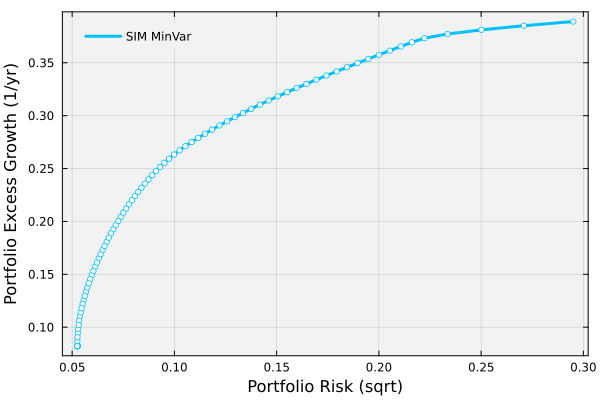

In [39]:
let
    plot(efficient_frontier, label="SIM MinVar", lw=3, c=:deepskyblue1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    scatter!(efficient_frontier, label="", c=:white, msc=:deepskyblue1, ms=3)
    xlabel!("Portfolio Risk (sqrt)", fontsize=18)
    ylabel!("Portfolio Excess Growth (1/yr)", fontsize=18)
end

In [40]:
i_see_the_efficient_frontier = true; # If you see the plot, then set the `i_see_the_efficient_frontier` variable to `true`.

### Build a test portfolio
Now that we have the efficient frontier, we can select a portfolio to explore. To begin, specify a desired portfolio growth rate in the `desired_growth_rate` variable:

In [42]:
desired_growth_rate = 0.25; # select a desired *excess* return

Next, resolve the minimum variance problem for the single-index models, assuming the `desired_growth_rate` value you specified. Update the `problem_risk` instance with your desired return level by setting the `R` field:

In [44]:
problem_risk.R = desired_growth_rate; # update the problem with your desired level of retirn

Resolve the minimum-variance allocation problem for the updated problem instance. The solution is returned in the `solution_min_var::Dict{String, Any}` dictionary. The return is stored in the `reward` field, while the portfolio weight vector $\omega$ is stored in the `argmax` field (this is a `N`$\times$ `1` array of $\omega_{i}$ values):

In [46]:
solution_min_var = nothing;
try
    solution_min_var = solve(problem_risk);
catch err
    # uncoment below to see error message
    println("What the what? Something happened: $(err)");
end

Dict{String, Any} with 4 entries:
  "argmax"          => [0.126662, 0.107029, 0.00178854, 0.223049, 0.282855, 2.0…
  "reward"          => 0.25
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.00851392

Finally, now that we have selected a portfolio, let's compute the number of shares of each asset we need to purchase. Save these values in the `MINVAR_Nₒ::Array{Float64,1}` variable. 

In [48]:
MINVAR_Nₒ = let
    N = length(my_list_of_tickers);
    Nₒ = Array{Float64,1}()
    ω = solution_min_var["argmax"];
    for i ∈ eachindex(my_list_of_tickers)
        
        wᵢ = abs(ω[i]); # min var allocation
        nᵢ = (wᵢ*my_total_budget)/Sₒ[i];
        push!(Nₒ,nᵢ)
    end
    Nₒ
end;

`Unhide` the code block below to see how we made an initial allocation table. 
* The column `ticker` holds the firms in our portfolio, the column `w` holds the portfolio weight for that asset, the column `n` is the number of shares that we purchased near market close on `startdate::Date,` the `initial_share_price` column is the price per share of each ticker, and the `value` column holds the cash (liquidation) value of each position at market close on `startdate::Date.`

In [50]:
let
    ω = solution_min_var["argmax"];
    df = DataFrame();
    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i]; # get the ticker
        value = MINVAR_Nₒ[i]*Sₒ[i];

        row_df = (
            ticker = ticker,
            w = abs(ω[i]), # small negatives
            n = MINVAR_Nₒ[i],
            initial_share_price = Sₒ[i],
            value = value
        )
        push!(df, row_df);
    end

    footer = (
        ticker = "total",
        w = sum(ω),
        n = sum(MINVAR_Nₒ),
        initial_share_price = 0,
        value = sum(MINVAR_Nₒ.*Sₒ)
    )
    push!(df, footer)
    
    pretty_table(df, tf=tf_simple)   
end

========= ============ ============ ===================== =============
  ticker            w            n   initial_share_price        value 
  String      Float64      Float64               Float64      Float64 
========= ============ ============ ===================== =============
    NVDA     0.126662      2.66271                47.569      126.662
     AMD     0.107029     0.790935                135.32      107.029
      MU   0.00178854    0.0217425                 82.26      1.78854
    AAPL     0.223049      1.21058                184.25      223.049
    MSFT     0.282855     0.763236                 370.6      282.855
      GS   2.03895e-8    5.3405e-8                381.79   2.03895e-5
     BAC   2.71035e-9   8.08336e-8                 33.53   2.71035e-6
     JPM   2.69682e-8   1.57405e-7                171.33   2.69682e-5
     WFC   2.47083e-9   5.07567e-8                 48.68   2.47083e-6
     MRK   0.00622207    0.0542134                114.77      6.22207
     PFE   2.6

### Simulate Minimum Variance Portfolio Wealth
Simulate the performance of the minimum variance portfolio starting from `startdate::Date` and ending on the last day of data available in the out-of-sample dataset. Store the wealth values in the `wealth_array_minimum_variance::Array{Float64,2}` array.
* __What's the story with the `let` block__? A [let block](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Let-Blocks) creates a new hard scope and introduces new variable bindings each time they run. Thus, they act like a private scratch space, where data comes in (is captured by the block), but only what we want to be exposed comes out. In this case, we want the block to export the wealth, allocation, and beta arrays.
* The `wealth_array_minimum_variance::Array{Float64,2}` array holds the wealth (liquidation value) of each asset $a\in\mathcal{P}$, and the total value in the last column. Each row of the `wealth_array_minimum_variance::Array{Float64,2}` array holds a trading period.
* To get the value of the close prices for each trading day i, we use the market(...) function.

In [52]:
wealth_array_minimum_variance = let

    N = length(my_list_of_tickers);
    wealth_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); # last col is the total
    for i = 1:(number_of_trading_days - 1)

        # get the close price array -
        close_price_array = market(out_of_sample_dataset, my_list_of_tickers, i); # gets the close price for today
        
        # compute the wealth array -
        for j ∈ eachindex(my_list_of_tickers)
           wealth_array[i,j] = MINVAR_Nₒ[j]*close_price_array[j];
        end
        wealth_array[i,end] = sum(wealth_array[i,1:end-1]);        
    end
    wealth_array
end;

## Task 2: Compute Equally Weighted Portfolio
In this task, we'll construct an equally weighted portfolio of the assets that you specified in the `my_list_of_tickers::Array{String,1}` array. The initial share prices were computed above, so let's start the equally weighted case by computing the number of shares we purchase to initiate the portfolio. We store these values in the `EQW_Nₒ::Array{Float64,1}` variable. The initial number of shares is given by:
$$
n_{a} = \frac{1}{N}\cdot\left(\frac{\mathcal{B}}{S_{\circ,a}}\right)\quad\forall{a}\in\mathcal{P}
$$
where $\mathcal{B}$ is the inital investment budget, $S_{\circ,a}$ is the initial share price for asset $a$, and $\omega_{a}$ denotes the allocation fraction for asset $a$. In this case, we have an equal partition, so $\omega_{a} = 1/N$ where $N$ is the number of assets in the portfolio. 

In [54]:
EQW_Nₒ = let
    N = length(my_list_of_tickers);
    Nₒ = Array{Float64,1}()
    for i ∈ eachindex(my_list_of_tickers)
        
        wᵢ = 1/N; # equal weight allocation
        nᵢ = (wᵢ*my_total_budget)/Sₒ[i];
        push!(Nₒ,nᵢ)
    end
    Nₒ
end;

`Unhide` the code block below to see how we made an initial allocation table for the equally weighted portfolio.
* The column `ticker` holds the firms in our portfolio, the column `w` holds the portfolio weight for that asset, the column `n` is the number of shares that we purchased near market close on `startdate::Date,` the `initial_share_price` column is the price per share of each ticker, and the `value` column holds the cash (liquidation) value of each position at market close on `startdate::Date.`

In [56]:
let
    df = DataFrame();
    N = length(my_list_of_tickers);
    w = (1/N)*ones(N);

    for i ∈ eachindex(my_list_of_tickers)
        ticker = my_list_of_tickers[i]; # get the ticker
        value = EQW_Nₒ[i]*Sₒ[i];

        row_df = (
            ticker = ticker,
            w = w[i],
            n = EQW_Nₒ[i],
            initial_share_price = Sₒ[i],
            value = value
        )
        push!(df, row_df);
    end

    footer = (
        ticker = "total",
        w = sum(w),
        n = sum(EQW_Nₒ),
        initial_share_price = 0,
        value = sum(EQW_Nₒ.*Sₒ)
    )
    push!(df, footer)
    
    pretty_table(df, tf=tf_simple)   
end

========= ========= =========== ===================== ==========
  ticker         w           n   initial_share_price     value 
  String   Float64     Float64               Float64   Float64 
========= ========= =========== ===================== ==========
    NVDA    0.0625     1.31388                47.569      62.5
     AMD    0.0625    0.461868                135.32      62.5
      MU    0.0625    0.759786                 82.26      62.5
    AAPL    0.0625    0.339213                184.25      62.5
    MSFT    0.0625    0.168645                 370.6      62.5
      GS    0.0625    0.163703                381.79      62.5
     BAC    0.0625       1.864                 33.53      62.5
     JPM    0.0625    0.364793                171.33      62.5
     WFC    0.0625     1.28389                 48.68      62.5
     MRK    0.0625    0.544567                114.77      62.5
     PFE    0.0625     2.10225                 29.73      62.5
     JNJ    0.0625    0.388271                160

### Simulation Equally Weighted Portfolio
Simulate the performance of the equally weighted portfolio starting from `startdate::Date` and ending on the last day of data available in the out-of-sample dataset. Store the wealth values in the `wealth_array_equally_weighted::Array{Float64,2}` array.
* __What's the story with the `let` block__? A [let block](https://docs.julialang.org/en/v1/manual/variables-and-scoping/#Let-Blocks) creates a new hard scope and introduces new variable bindings each time they run. Thus, they act like a private scratch space, where data comes in (is captured by the block), but only what we want to be exposed comes out. In this case, we want the block to export the wealth, allocation, and beta arrays.
* The `wealth_array_equally_weighted::Array{Float64,2}` array holds the wealth (liquidation value) of each asset $a\in\mathcal{P}$, and the total value in the last column. Each row of the `wealth_array_equally_weighted::Array{Float64,2}` array holds a trading period.
* To get the value of the close prices for each trading day `i`, we use [the `market(...)` function](src/Compute.jl).

In [58]:
wealth_array_equally_weighted = let

    N = length(my_list_of_tickers);
    wealth_array = Array{Float64,2}(undef, number_of_trading_days - 1, N+1); # last col is the total
    for i = 1:(number_of_trading_days - 1)

        # get the close price array -
        close_price_array = market(out_of_sample_dataset, my_list_of_tickers, i); # gets the close price for today
        
        # compute the wealth array -
        for j ∈ eachindex(my_list_of_tickers)
           wealth_array[i,j] = EQW_Nₒ[j]*close_price_array[j];
        end
        wealth_array[i,end] = sum(wealth_array[i,1:end-1]);        
    end
    wealth_array
end;

## Task 3: Which approach should we choose?
In this task, we'll compare the three investment approaches and determine which performs better. In particular, we'll plot the wealth array for the minimum variance portfolio, the equally weighted portfolio, and the [SP500 `SPY` ETF](https://finance.yahoo.com/quote/SPY/) for `2024`.

### Visualize your wealth array
`Unhide` the code block below to see how we plotted the wealth arrays for the three approaches. Depending upon your choice of assets, you could over- or under-perform [the `SPY` ETF](https://finance.yahoo.com/quote/SPY/).

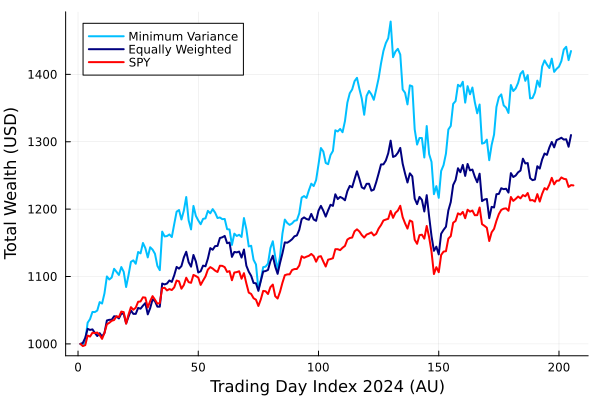

In [61]:
let
    plot(wealth_array_minimum_variance[:,end], lw=2, c=:deepskyblue1, label="Minimum Variance")
    plot!(wealth_array_equally_weighted[:,end], lw=2, c=:navy, label="Equally Weighted")
    plot!(n_spy*S_spy, c=:red, lw=2, label="SPY")
    xlabel!("Trading Day Index 2024 (AU)", fontsize=18);
    ylabel!("Total Wealth (USD)", fontsize=18)
end

In [104]:
i_see_the_wealth_plot = true; # If you see the wealth plot, then set the `i_see_the_wealth_plot` variable to `true`.

### Winner?
Let's rank the approaches based on the final wealth value (this is not the only way to do this, but it's the simplest):

In [108]:
labels = ["SPY", "MINVAR", "EQW"]; # create a label array
W = [(n_spy*S_spy)[end], wealth_array_minimum_variance[end], wealth_array_equally_weighted[end]];
sortperm(W, rev=true) |> i -> labels[i]

3-element Vector{String}:
 "MINVAR"
 "EQW"
 "SPY"

## Tests
In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [110]:
let

    @testset verbose = true "CHEME 5660 problem set 4 test suite" begin

        @testset "Task 1: Minimum Variance Portfolio Tests" begin
            @test length(my_list_of_tickers) ≥ 10
            @test typeof(problem_risk) == MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem
            @test isempty(efficient_frontier) == false
            @test solution_min_var != nothing
            @test isempty(wealth_array_minimum_variance) == false
            @test i_see_the_efficient_frontier == true
        end

        @testset "Task 2: Equally Weighted Portfolio Tests" begin
            @test isempty(EQW_Nₒ) == false
            @test isempty(wealth_array_equally_weighted) == false
        end

        @testset "Task 3: Wealth Tests" begin
            @test i_see_the_wealth_plot == true;
        end
    end
end;

Task 1: Minimum Variance Portfolio Tests: Test Failed at In[110]:11
  Expression: i_see_the_efficient_frontier == true
   Evaluated: false == true

Stacktrace:
 [1] macro expansion
   @ ~/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Test/src/Test.jl:679 [inlined]
 [2] macro expansion
   @ In[110]:11 [inlined]
 [3] macro expansion
   @ ~/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Test/src/Test.jl:1700 [inlined]
 [4] macro expansion
   @ In[110]:6 [inlined]
 [5] macro expansion
   @ ~/.julia/juliaup/julia-1.11.1+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Test/src/Test.jl:1700 [inlined]
 [6] top-level scope
   @ In[110]:5
Test Summary:                              | Pass  Fail  Total  Time
CHEME 5660 problem set 4 test suite        |    8     1      9  0.0s
  Task 1: Minimum Variance Portfolio Tests |    5     1      6  0.0s
  Task 2: Equally Weighted Portfolio Tests |    2            2  0.0s
  Task 3: Wealth Tests

LoadError: [91mSome tests did not pass: 8 passed, 1 failed, 0 errored, 0 broken.[39m

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.